# The 8 schools example

The "8 schools" example is a famous example of a hierarchical (multi-level) model with so-called "partial pooling." The data comes from a study of coaching programs for the Verbal SAT (for those unfamiliar, the SAT is one of two major standardized tests used in undergraduate college/university admissions in the US).

Let's do our imports and load the data.

In [1]:
import numpy as np, scipy as sp, pymc3 as pm, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

d = {'School': ['A','B','C','D','E','F','G','H'],
     'Effect': [28, 8, -3, 7, -1, 1, 18, 12],
     'SE': [15, 10, 16, 11, 9, 11, 10, 18]}
schools = pd.DataFrame(data=d)
schools

,School,Effect,SE
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9
5,F,1,11
6,G,18,10
7,H,12,18


The estimates $y_i$ of the effects are obtained by independent experiments carried out at each school. The estimates are not simple sample means, as they underwent some adjustment procedures, but they can be assumed to have approximately normal sampling distributions with known standard errors (in the above table).

## Hierarchical model


### The model

We presume that the estimates $y_i$ are produced by 8 independent normal distributions with their own means $\theta_i$ and variances $\sigma^2_i$:

$$ y_i | \theta_i, \sigma^2_i \sim N(\theta_i, \sigma^2_i) $$

We presume that the parameters $\theta_i$ are themselves drawn from a normal distribution with parameters $\mu, \tau$. Given $\mu, \tau$, we assume the $\theta_i$'s to be conditionally independent.

For convenience, we presume the sampling standard deviations of the $\bar y_i$ to be known and equal to the values in the data table. 

In [2]:
with pm.Model() as hierarchical_model:
    # Hyperparameters
    eta = pm.Normal('eta', 0, 1, shape = 8)
    tau = pm.HalfCauchy('tau', 5)
    m = pm.Normal('m', mu = 0, sigma = 5)
    
    # Parameter vector
    
    theta = pm.Deterministic('theta', m + tau * eta)
    #theta = pm.Normal('theta', mu = m, sigma = tau, shape = 8)
    
    # Data likelihood
    y_obs = pm.Normal('y_obs', mu = theta, sigma = schools['SE'], observed = schools['Effect'])
    
    trace = pm.sample(2000, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m, tau, eta]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1221.26draws/s]


In [3]:
pm.summary(trace, var_names=['m', 'theta', 'tau'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,4.468,3.260,-1.741,10.552,0.052,0.041,3931.0,3141.0,3925.0,2786.0,1.0
theta[0],6.276,5.494,-2.869,17.482,0.086,0.068,4045.0,3248.0,4294.0,3783.0,1.0
theta[1],4.918,4.605,-3.907,13.758,0.074,0.063,3901.0,2659.0,3986.0,3023.0,1.0
theta[2],3.911,5.121,-6.467,13.203,0.074,0.063,4731.0,3330.0,4755.0,3525.0,1.0
theta[3],4.800,4.803,-4.560,13.663,0.073,0.056,4308.0,3646.0,4372.0,3143.0,1.0
theta[4],3.713,4.538,-4.593,12.758,0.066,0.056,4663.0,3314.0,4682.0,3372.0,1.0
theta[5],4.147,4.817,-5.596,12.510,0.071,0.056,4627.0,3674.0,4852.0,3406.0,1.0
theta[6],6.385,4.992,-2.838,15.679,0.077,0.059,4212.0,3521.0,4367.0,3751.0,1.0
theta[7],4.979,5.151,-4.826,14.550,0.082,0.062,3946.0,3399.0,4065.0,3228.0,1.0
tau,3.618,3.198,0.003,9.285,0.057,0.041,3186.0,3070.0,2744.0,2168.0,1.0


<AxesSubplot:title={'center':'scatter plot between log(tau) and theta[0]'}, xlabel='theta[0]', ylabel='log(tau)'>

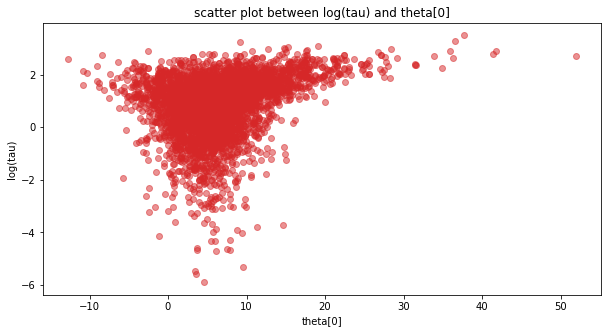

In [4]:
def pairplot_divergence(trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    theta = trace.get_values(varname='theta', combine=True)[:, 0]
    logtau = trace.get_values(varname='tau_log__', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('log(tau)')
    ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

pairplot_divergence(trace)

In [5]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
eta[0],0.311,0.979,-1.633,2.045,0.014,0.016,4759.0,1912.0,4765.0,3070.0,1.0
eta[1],0.102,0.930,-1.725,1.744,0.014,0.015,4734.0,1868.0,4731.0,2968.0,1.0
eta[2],-0.122,0.956,-1.904,1.630,0.014,0.018,4687.0,1426.0,4575.0,2458.0,1.0
eta[3],0.056,0.949,-1.808,1.793,0.013,0.016,4997.0,1760.0,4998.0,2976.0,1.0
eta[4],-0.154,0.921,-1.913,1.562,0.013,0.015,5187.0,1941.0,5202.0,3128.0,1.0
eta[5],-0.068,0.959,-1.796,1.761,0.013,0.015,5275.0,1981.0,5308.0,2879.0,1.0
eta[6],0.384,0.967,-1.515,2.125,0.014,0.014,4915.0,2333.0,4905.0,2675.0,1.0
eta[7],0.083,0.983,-1.730,1.997,0.014,0.017,5008.0,1742.0,5022.0,2606.0,1.0
m,4.468,3.260,-1.741,10.552,0.052,0.041,3931.0,3141.0,3925.0,2786.0,1.0
tau,3.618,3.198,0.003,9.285,0.057,0.041,3186.0,3070.0,2744.0,2168.0,1.0
